In [1]:
import os
import time
import matplotlib.pyplot as plt
import requests
import json
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr, row_number
from pyspark.sql.window import Window
spark = (SparkSession.builder.appName("cs544")
         .master("spark://main:7077")
         .config("spark.executor.memory", "512M")
         .config("spark.sql.warehouse.dir", "hdfs://main:9000/user/hive/warehouse")
         .enableHiveSupport()
         .getOrCreate())
sc = spark.sparkContext

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/03/31 22:46:10 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
#Part 1: Data Setup

In [3]:
#hardcoded data for project reference 
files = ["https://pages.cs.wisc.edu/~harter/cs639/data/hdma-wi-2021.zip", 
 "https://pages.cs.wisc.edu/~harter/cs639/data/arid2017_to_lei_xref_csv.zip",
"https://pages.cs.wisc.edu/~harter/cs639/data/code_sheets.zip"]

code_sheets = ["ethnicity", "race", "sex", "states", "counties", "tracts", "action_taken", "denial_reason", "loan_type", "loan_purpose", "preapproval", "property_type", "agency"]
arid2017_to_lei_xref_csv = ["arid2017_to_lei_xref_csv"]
hdma_wi_2021 = ["hdma_wi_2021"]

In [4]:
#download zip files and extract CSVs

paths = []
for path in files:
    csv = path.split('/')[-1]
    if not os.path.exists(f"{csv[0:-4]}/{csv}"):
        !mkdir {csv[0:-4]} && cd {csv[0:-4]} && wget {path} && unzip {csv} && cd ..
    else:
        print(f"{csv} already downloaded")
    paths.append(f"{csv[0:-4]}/")

hdma-wi-2021.zip already downloaded
arid2017_to_lei_xref_csv.zip already downloaded
code_sheets.zip already downloaded


In [5]:
#upload csv files to hadoop
csv_count = 0
resp = !hdfs dfs -du -h hdfs://main:9000/
for path in paths:
    for file in os.listdir(path):
        if ".csv" in file:
            found = False
            for item in resp:   
                if file in item:
                    found = True
                    break
            csv_count+=1
            if(found):
                print(f"{file} already in HDFS")
            else:
                !hdfs dfs -D dfs.block.size=1048576 -D dfs.replication=1 -cp {path+file} hdfs://main:9000/{file}
                print(f"{file} uploaded to HDFS")
            
resp = !hdfs dfs -du -h hdfs://main:9000/

hdma-wi-2021.csv uploaded to HDFS
arid2017_to_lei_xref_csv.csv uploaded to HDFS
tracts.csv uploaded to HDFS
edit_status.csv uploaded to HDFS
loan_type.csv uploaded to HDFS
counties.csv uploaded to HDFS
purchaser_type.csv uploaded to HDFS
lien_status.csv uploaded to HDFS
hoepa.csv uploaded to HDFS
agency.csv uploaded to HDFS
denial_reason.csv uploaded to HDFS
states.csv uploaded to HDFS
owner_occupancy.csv uploaded to HDFS
msamd.csv uploaded to HDFS
race.csv uploaded to HDFS
ethnicity.csv uploaded to HDFS
sex.csv uploaded to HDFS
loan_purpose.csv uploaded to HDFS
preapproval.csv uploaded to HDFS
property_type.csv uploaded to HDFS
action_taken.csv uploaded to HDFS


In [6]:
#create spark warehouse
for file in resp:
    csv_hadoop_path = file.split(" ")[-1]
    if "user" in csv_hadoop_path:
        continue
    df = (spark.read.format("csv")
        .option("header", True)
        .option("inferSchema", True)
        .load(csv_hadoop_path))
    csv_name = csv_hadoop_path.split("/")[-1].replace('-','_')[0:-4]
    if csv_name in code_sheets:
        df.createOrReplaceTempView(csv_name)
    elif csv_name in arid2017_to_lei_xref_csv:
        df.write.saveAsTable("banks", mode="overwrite")
    elif csv_name in hdma_wi_2021:
        df.write.bucketBy(8, "county_code").saveAsTable("loans", mode="overwrite")

23/03/31 22:48:02 WARN HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
23/03/31 22:48:02 WARN HiveConf: HiveConf of name hive.stats.retries.wait does not exist
23/03/31 22:48:07 WARN ObjectStore: Version information not found in metastore. hive.metastore.schema.verification is not enabled so recording the schema version 2.3.0
23/03/31 22:48:07 WARN ObjectStore: setMetaStoreSchemaVersion called but recording version is disabled: version = 2.3.0, comment = Set by MetaStore UNKNOWN@172.19.0.2
23/03/31 22:48:08 WARN ObjectStore: Failed to get database global_temp, returning NoSuchObjectException
23/03/31 22:48:08 WARN HadoopFSUtils: The directory hdfs://main:9000/user/hive/warehouse/banks was not found. Was it deleted very recently?
23/03/31 22:48:10 WARN FileUtils: File does not exist: hdfs://main:9000/user/hive/warehouse/banks; Force to delete it.
23/03/31 22:48:10 ERROR FileUtils: Failed to delete hdfs://main:9000/user/hive/warehouse/banks
23/03/31 22:48:13 WARN Sessio

In [7]:
#Q1: what tables are in our warehouse?

spark.sql("SHOW TABLES").show()
#expected results
# +---------+-------------+-----------+
# |namespace|    tableName|isTemporary|
# +---------+-------------+-----------+
# |  default|        banks|      false|
# |  default|        loans|      false|
# |         | action_taken|       true|
# |         |       agency|       true|
# |         |     counties|       true|
# |         |denial_reason|       true|
# |         |    ethnicity|       true|
# |         | loan_purpose|       true|
# |         |    loan_type|       true|
# |         |  preapproval|       true|
# |         |property_type|       true|
# |         |         race|       true|
# |         |          sex|       true|
# |         |       states|       true|
# |         |       tracts|       true|
# +---------+-------------+-----------+

+---------+-------------+-----------+
|namespace|    tableName|isTemporary|
+---------+-------------+-----------+
|  default|        banks|      false|
|  default|        loans|      false|
|         | action_taken|       true|
|         |       agency|       true|
|         |     counties|       true|
|         |denial_reason|       true|
|         |    ethnicity|       true|
|         | loan_purpose|       true|
|         |    loan_type|       true|
|         |  preapproval|       true|
|         |property_type|       true|
|         |         race|       true|
|         |          sex|       true|
|         |       states|       true|
|         |       tracts|       true|
+---------+-------------+-----------+



In [8]:
#Part 2: Filter and Join

In [9]:
#Q2: how many banks contain the word "first" in their name? Which ones contain "second"?

spark.sql("""
SELECT DISTINCT COUNT(respondent_name) AS num_banks_containing_word_first
FROM (
    SELECT DISTINCT UPPER(respondent_name) AS respondent_name
    FROM banks
    )
WHERE respondent_name LIKE '%FIRST%'
""").toPandas()

,num_banks_containing_word_first
0,449


In [10]:
#Q2: how many banks contain the word "first" in their name? Which ones contain "second"?

spark.sql("""
SELECT respondent_name AS banks_containing_word_second
FROM (
    SELECT UPPER(respondent_name) AS respondent_name
    FROM banks
    )
WHERE respondent_name LIKE '%SECOND%'
""").toPandas()

,banks_containing_word_second
0,OLD SECOND NATIONAL BANK


In [11]:
#Q3: how many loan applications has your "favorite" bank received in the dataset?
#bank chosen: Wells Fargo

cond = [spark.table("banks")["lei_2018"] == spark.table("loans")["lei"], 
        spark.table("banks")["lei_2019"] == spark.table("loans")["lei"], 
        spark.table("banks")["lei_2020"] == spark.table("loans")["lei"]]
result = (spark.table("banks")
          .join(spark.table("loans"), cond, how="inner")
          .select("respondent_name")
          .where("respondent_name LIKE '%Wells Fargo%'")
         )
result.count()

12487

In [12]:
#Q4: what does results.explain("formatted") tell us about Spark's query plan for Q3?

result.explain("formatted")
# 1. which table is sent to every executor via a BroadcastExchange operation?
#    banks
# 2. on which tables is "is not null" filtering added by the optimizer?
#    both banks and loans
# 3. which Functions do the HashAggregates use?
#    none


== Physical Plan ==
AdaptiveSparkPlan (8)
+- Project (7)
   +- BroadcastHashJoin Inner BuildLeft (6)
      :- BroadcastExchange (3)
      :  +- Filter (2)
      :     +- Scan parquet default.banks (1)
      +- Filter (5)
         +- Scan parquet default.loans (4)


(1) Scan parquet default.banks
Output [4]: [respondent_name#1093, lei_2018#1095, lei_2019#1096, lei_2020#1097]
Batched: true
Location: InMemoryFileIndex [hdfs://main:9000/user/hive/warehouse/banks]
PushedFilters: [IsNotNull(respondent_name), StringContains(respondent_name,Wells Fargo), IsNotNull(lei_2018), IsNotNull(lei_2019), IsNotNull(lei_2020)]
ReadSchema: struct<respondent_name:string,lei_2018:string,lei_2019:string,lei_2020:string>

(2) Filter
Input [4]: [respondent_name#1093, lei_2018#1095, lei_2019#1096, lei_2020#1097]
Condition : (((((((isnotnull(respondent_name#1093) AND Contains(respondent_name#1093, Wells Fargo)) AND (lei_2019#1096 = lei_2018#1095)) AND (lei_2020#1097 = lei_2018#1095)) AND (lei_2020#1097 = lei_201

In [13]:
#Q5: what are the top 10 biggest loans (in terms of loan_amount) that were approved by your favorite bank?

banks = spark.table("banks")
loans = spark.table("loans")
action_taken = spark.table("action_taken")
loan_purpose = spark.table("loan_purpose")
counties = spark.table("counties")

#separate loans table county_code into state and county columns and create dataframe
loans_county_code_separated = (loans
         .withColumn("state", expr("substring(county_code, 0, 2)"))
         .withColumn("state", col("state").cast("Int"))
         .withColumn("county", expr("substring(county_code, 3)"))
         .withColumn("county", col("county").cast("Int"))
)
#create distinct counties dataframe
distinct_counties = (counties
                     .distinct()
                     .withColumn("state", col("state").cast("Int"))
                     .withColumn("county", col("county").cast("Int"))
                    )
#left join loans and counties
cond = (
    [loans_county_code_separated["state"] == distinct_counties["state"], 
     loans_county_code_separated["county"] == distinct_counties["county"]]
)
loans_leftjoin_counties = (loans_county_code_separated
                           .join(distinct_counties.select("name", "state", "county"), cond, how="left")
                          )

#FAILED CODE FOR REFERENCE ONLY: TRIED TO COMBINE STATE AND COUNTY CODES IN COUNTIES TABLE
#combine state and county into county code
# distinct_county_codes = (
#     counties
#     .distinct()
#     .withColumn("COUNTY_CODE1", expr("STATE || COUNTY"))
#     .withColumn("COUNTY_CODE1",col("COUNTY_CODE1")
#                 .cast("Int"))
#     .withColumn("COUNTY_CODE2", expr("STATE ||'0'|| COUNTY"))
#     .withColumn("COUNTY_CODE2",col("COUNTY_CODE2")
#                 .cast("Int"))
# )


#left join loans & action taken
loans_counties_action = (
    loans_leftjoin_counties
    .join(action_taken, on=loans_leftjoin_counties["action_taken"] == action_taken["id"], how="left")
                        )
#left join loans & loan_purpose
loans_counties_action_purpose = (
    loans_counties_action
    .join(loan_purpose, on=loans_counties_action["loan_purpose"] == loan_purpose["id"], how="left")
                                )
#inner join banks & loans failed attempts 
#FAILED CODE: CONDITION LIST IS 'AND' CONDITION BY DEFAULT
# cond = (
#      banks["lei_2018"] == loans_counties_action_purpose["lei"] | \
#      banks["lei_2019"] == loans_counties_action_purpose["lei"] | \
#      banks["lei_2020"] == loans_counties_action_purpose["lei"]
#        )

#FAILED CODE: OR '|' NOT COMPATIBLE WITH CONDITION LIST 
# main = banks.join( \
#     loans_counties_action_purpose,                                  \
#     banks["lei_2018"] == loans_counties_action_purpose["lei"] |     \
#         banks["lei_2019"] == loans_counties_action_purpose["lei"] | \
#         banks["lei_2020"] == loans_counties_action_purpose["lei"],  \
#     how="left")

#FAILED CODE: RUNS, BUT OR OPERATION IS SO EXPENSIVE THAT THE TIME IT TAKES IS UNNACCEPTABLE AND THUS CAUSES A TIMEOUT ERROR
# main = banks.join( \
#     loans_counties_action_purpose,                                  \
#         (banks["lei_2020"] == loans_counties_action_purpose["lei"]) | (banks["lei_2019"] == loans_counties_action_purpose["lei"]) | (banks["lei_2018"] == loans_counties_action_purpose["lei"]),  \
#     how="left")

#inner join banks and loans
main = banks.join( \
    loans_counties_action_purpose,                                  \
        (banks["lei_2020"] == loans_counties_action_purpose["lei"]),  \
    how="inner")

#grab required columns and top 10 approved loans for wells fargo
df = (
    main.select(
        "census_tract",
        expr("name").alias("county"),
        "loan_purpose.loan_purpose", 
        "derived_dwelling_category",
        expr("loan_amount / 1000").alias("thousands"),
        "interest_rate",
        expr("loan_term / 12").alias("years"),
        "action_taken.action_taken")
    .where("respondent_name LIKE '%Wells Fargo%'")
     )
df.orderBy("loan_amount",ascending=False).where(df["action_taken"] == "Loan originated").limit(10).toPandas()

,census_tract,county,loan_purpose,derived_dwelling_category,thousands,interest_rate,years,action_taken
0,55085971300,Oneida,None,Single Family (1-4 Units):Site-Built,3005.0,2.375,15.0,Loan originated
1,55063000400,La Crosse,None,Multifamily:Site-Built,2405.0,3.6,10.0,Loan originated
2,55007960600,Bayfield,None,Single Family (1-4 Units):Site-Built,1655.0,2.375,30.0,Loan originated
3,55025012700,Dane,None,Single Family (1-4 Units):Site-Built,1645.0,3.25,30.0,Loan originated
4,55079014300,Milwaukee,None,Single Family (1-4 Units):Site-Built,1585.0,2.625,15.0,Loan originated
5,55127000302,Walworth,Home purchase,Single Family (1-4 Units):Site-Built,1545.0,1.875,30.0,Loan originated
6,55089660304,Ozaukee,None,Single Family (1-4 Units):Site-Built,1465.0,2.75,30.0,Loan originated
7,55089660303,Ozaukee,None,Single Family (1-4 Units):Site-Built,1455.0,3.0,30.0,Loan originated
8,55079070200,Milwaukee,None,Single Family (1-4 Units):Site-Built,1405.0,2.875,30.0,Loan originated
9,55125950600,Vilas,None,Single Family (1-4 Units):Site-Built,1325.0,2.5,30.0,Loan originated


In [14]:
#Part 3: GROUPY BY and Windowing

In [26]:
#Q6: when computing a MEAN aggregate per group of loans, when do we require network I/O between the partial_mean and mean 
#operations?

#for mean aggegate on the county_code column no network I/O was required, but for mean aggegate on the lei column an Exchange operation occurs
#requiring network I/O


meanAgg_county = (spark.table("loans")
           .select("county_code", "lei","loan_amount", col("interest_rate").cast("Double"), col("loan_term").cast("Int"))
           .groupby("county_code")
           .mean("loan_amount", "interest_rate", "loan_term")
          )
meanAgg_county.explain("formatted")

== Physical Plan ==
AdaptiveSparkPlan (5)
+- HashAggregate (4)
   +- HashAggregate (3)
      +- Project (2)
         +- Scan parquet default.loans (1)


(1) Scan parquet default.loans
Output [4]: [county_code#1117, loan_amount#1134, interest_rate#1136, loan_term#1144]
Batched: true
Location: InMemoryFileIndex [hdfs://main:9000/user/hive/warehouse/loans]
ReadSchema: struct<county_code:string,loan_amount:double,interest_rate:string,loan_term:string>
SelectedBucketsCount: 8 out of 8

(2) Project
Output [4]: [county_code#1117, loan_amount#1134, cast(interest_rate#1136 as double) AS interest_rate#5383, cast(loan_term#1144 as int) AS loan_term#5384]
Input [4]: [county_code#1117, loan_amount#1134, interest_rate#1136, loan_term#1144]

(3) HashAggregate
Input [4]: [county_code#1117, loan_amount#1134, interest_rate#5383, loan_term#5384]
Keys [1]: [county_code#1117]
Functions [3]: [partial_avg(loan_amount#1134), partial_avg(interest_rate#5383), partial_avg(loan_term#5384)]
Aggregate Attributes [6

In [27]:
#Q6: when computing a MEAN aggregate per group of loans, when do we require network I/O between the partial_mean and mean 
#operations?

meanAgg_lei = (spark.table("loans")
           .select("county_code", "lei","loan_amount", col("interest_rate").cast("Double"), col("loan_term").cast("Int"))
           .groupby("lei")
           .mean("loan_amount", "interest_rate", "loan_term")
          )
meanAgg_lei.explain("formatted")

== Physical Plan ==
AdaptiveSparkPlan (6)
+- HashAggregate (5)
   +- Exchange (4)
      +- HashAggregate (3)
         +- Project (2)
            +- Scan parquet default.loans (1)


(1) Scan parquet default.loans
Output [4]: [lei#1114, loan_amount#1134, interest_rate#1136, loan_term#1144]
Batched: true
Location: InMemoryFileIndex [hdfs://main:9000/user/hive/warehouse/loans]
ReadSchema: struct<lei:string,loan_amount:double,interest_rate:string,loan_term:string>

(2) Project
Output [4]: [lei#1114, loan_amount#1134, cast(interest_rate#1136 as double) AS interest_rate#5516, cast(loan_term#1144 as int) AS loan_term#5517]
Input [4]: [lei#1114, loan_amount#1134, interest_rate#1136, loan_term#1144]

(3) HashAggregate
Input [4]: [lei#1114, loan_amount#1134, interest_rate#5516, loan_term#5517]
Keys [1]: [lei#1114]
Functions [3]: [partial_avg(loan_amount#1134), partial_avg(interest_rate#5516), partial_avg(loan_term#5517)]
Aggregate Attributes [6]: [sum#5538, count#5539L, sum#5540, count#5541L, sum

<Axes: xlabel='name', ylabel='Average Interest Rate'>

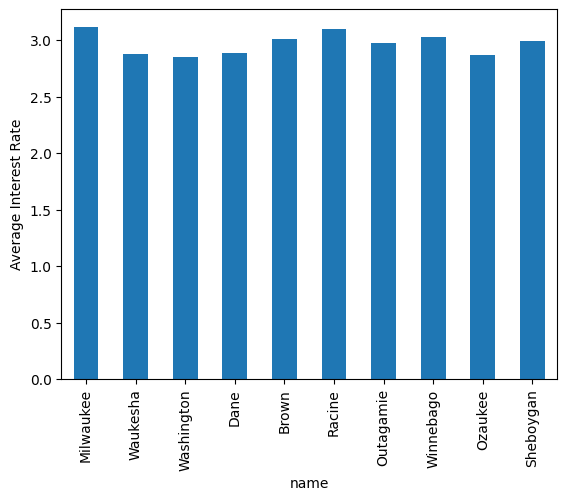

In [16]:
#Q7: what are the average interest rates for Wells Fargo applications for the ten counties where Wells Fargo receives the 
#most applications?

main = main.withColumn("interest_rate", col("interest_rate").cast("Double"))

answer = (main
          .select("respondent_name", "interest_rate", expr("name"))
          .where("respondent_name LIKE '%Wells Fargo%'")
          .groupby("name")
          .agg(expr("COUNT(name)").alias("application_count"), expr("AVG(interest_rate)").alias("avg_interest_rate"))
          .orderBy("application_count", ascending=False)
)
df = answer.limit(10).toPandas()

df = df.drop(columns="application_count")
df.set_index("name").plot.bar(legend=None, ylabel="Average Interest Rate")

<Axes: xlabel='name', ylabel='2nd Biggest Loan Application (Millions $)'>

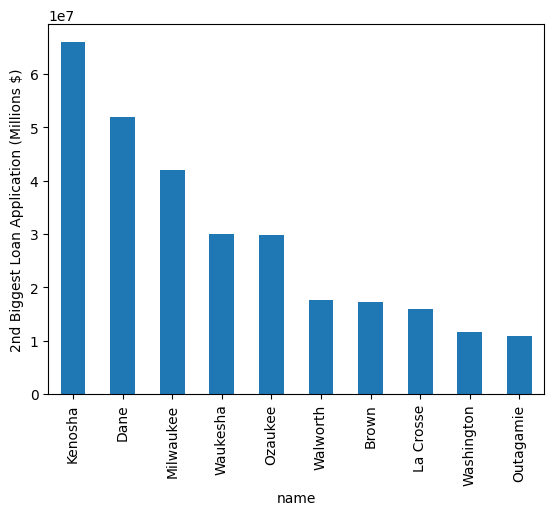

In [17]:
#Q8: what is the second biggest loan application amount in each county? (answer for top 10 counties)
#main_noDupliates = main.dropDuplicates()

cond = (
    [loans_county_code_separated["state"] == distinct_counties["state"], 
     loans_county_code_separated["county"] == distinct_counties["county"]]
)

loans_innerjoin_counties = loans_county_code_separated.join(distinct_counties.select("name", "state", "county"), cond, how="inner")

answer = (loans_innerjoin_counties
        .dropDuplicates()
        .select("name", "loan_amount", expr("row_number() OVER(PARTITION BY name ORDER BY loan_amount DESC) AS rank"))
).select("*").where("name != 'None' AND rank == 2").orderBy("loan_amount", ascending=False).limit(10)

df = answer.toPandas()
df = df.drop(columns="rank")
df.set_index("name").plot.bar(legend=None, ylabel="2nd Biggest Loan Application (Millions $)")

In [18]:
#Part 4: Caching

df = spark.sql("""
    SELECT interest_rate
    FROM banks
    INNER JOIN loans
    ON banks.lei_2020 = loans.lei 
    WHERE banks.respondent_name = 'Wells Fargo Bank, National Association'
""")

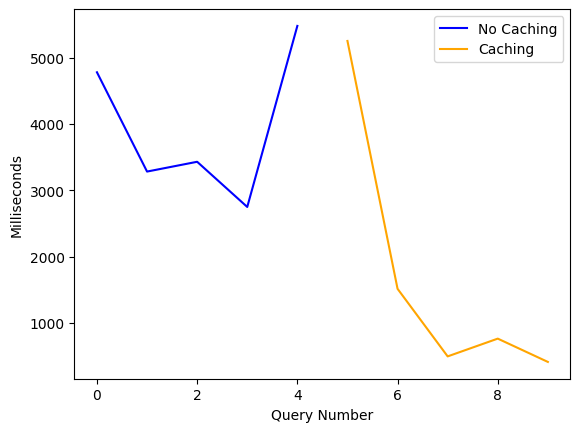

In [19]:
#Q9: what is the cost of caching and the impact on subsequent queries?

q9_a = {}
q9_b = {}
for i in range(10):
    if i < 5:
        t0 = time.time()
        df.count()
        t1 = time.time()
        q9_a[i] = (t1-t0)*1000
        if i == 4:
            df.cache()
    else:
        t0 = time.time()
        df.count()
        t1 = time.time()
        q9_b[i] = (t1-t0)*1000
df.unpersist() 

plt.plot(q9_a.keys(), q9_a.values(), c='blue', label="No Caching")
plt.plot(q9_b.keys(),q9_b.values(), c='orange', label="Caching")
plt.legend()
plt.xlabel("Query Number")
plt.ylabel("Milliseconds")
plt.show()

numPartitions 2 not 1, repartitioning...


partitions: 1


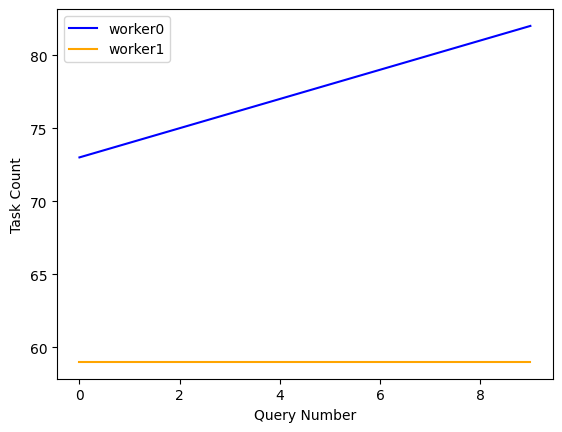

In [20]:
#Q10: what is the impact of caching a single partition on load balance?

numPartitions = df.rdd.getNumPartitions()
if numPartitions != 1:
    df = df.repartition(1)
    print(f"numPartitions {numPartitions} not 1, repartitioning...")
print(f"partitions: {df.rdd.getNumPartitions()}")
df.cache()

response = json.loads(requests.get("http://localhost:4040/api/v1/applications").text)
app_id = response[0]["id"]

q10_a = {}
q10_b = {}
for i in range(10):
    df.count()
    response = json.loads(requests.get(f"http://localhost:4040/api/v1/applications/{app_id}/executors").text)
    q10_a[i] = response[1]["totalTasks"]
    q10_b[i] = response[2]["totalTasks"]
df.unpersist()

plt.close()
plt.plot(q10_a.keys(), q10_a.values(), c='blue', label= "worker0")
plt.plot(q10_b.keys(), q10_b.values(), c='orange', label="worker1")
plt.legend()
plt.xlabel("Query Number")
plt.ylabel("Task Count")
plt.show()